[19:41:57] System memory available: 10.91 GB
[19:41:57] Estimated peak memory use ~ 2.97 GB (rough)
[19:41:57] Building k-grid for rfftn domain (sliced in z)
[19:41:57] Generating random fields and creating spectral representations (rfftn)...
[19:42:03] Applying spectral amplitude scaling (approx k^-5/3)


/tmp/ipykernel_76213/396826430.py:106: RuntimeWarning: divide by zero encountered in power
  scale = np.where(mask, (K.astype(np.float32) ** (-5.0/6.0)).astype(COMPLEX_DTYPE), 0.0+0.0j)


[19:42:03] Applying solenoidal projection in spectral domain


/tmp/ipykernel_76213/396826430.py:118: RuntimeWarning: divide by zero encountered in divide
  invK2 = np.where(K2>0, 1.0 / K2, 0.0).astype(DTYPE)


[19:42:05] Inverse transform to physical space (irfftn) — storing as float32
[19:42:06] Velocity fields generated in 9.4s. Mean KE computing...
[19:42:06] Mean kinetic energy density (scalar): 2.413437e-04
[19:42:35] Saved velocity NPZ (compressed)
[19:42:35] Computing spectral gradients (will reuse temp spectral arrays sequentially to limit memory)
[19:42:43] Gradients computed (float32)
[19:42:43] Downsampling invariants with DS=4 (feature grid = 96^3)
[19:42:43] Computing lambda2 on downsampled grid (this is the most expensive pointwise op)
[19:42:45] Building feature matrix and standardizing
[19:42:45] Feature matrix shape: (884736, 4) (samples)
[19:42:45] Clustering with MiniBatchKMeans (k=12)
[19:42:46] MiniBatchKMeans completed in 0.7s
[19:42:46] N_eff (cutoff 0.5%): 12
[19:42:46] Saving CSV, NPZ and report
[19:42:46] Saved CSV: output_multiflux_optimized/cluster_volumes_384_optimized.csv, NPZ: output_multiflux_optimized/multiflux_384_optimized.npz, report: output_multiflux_opti

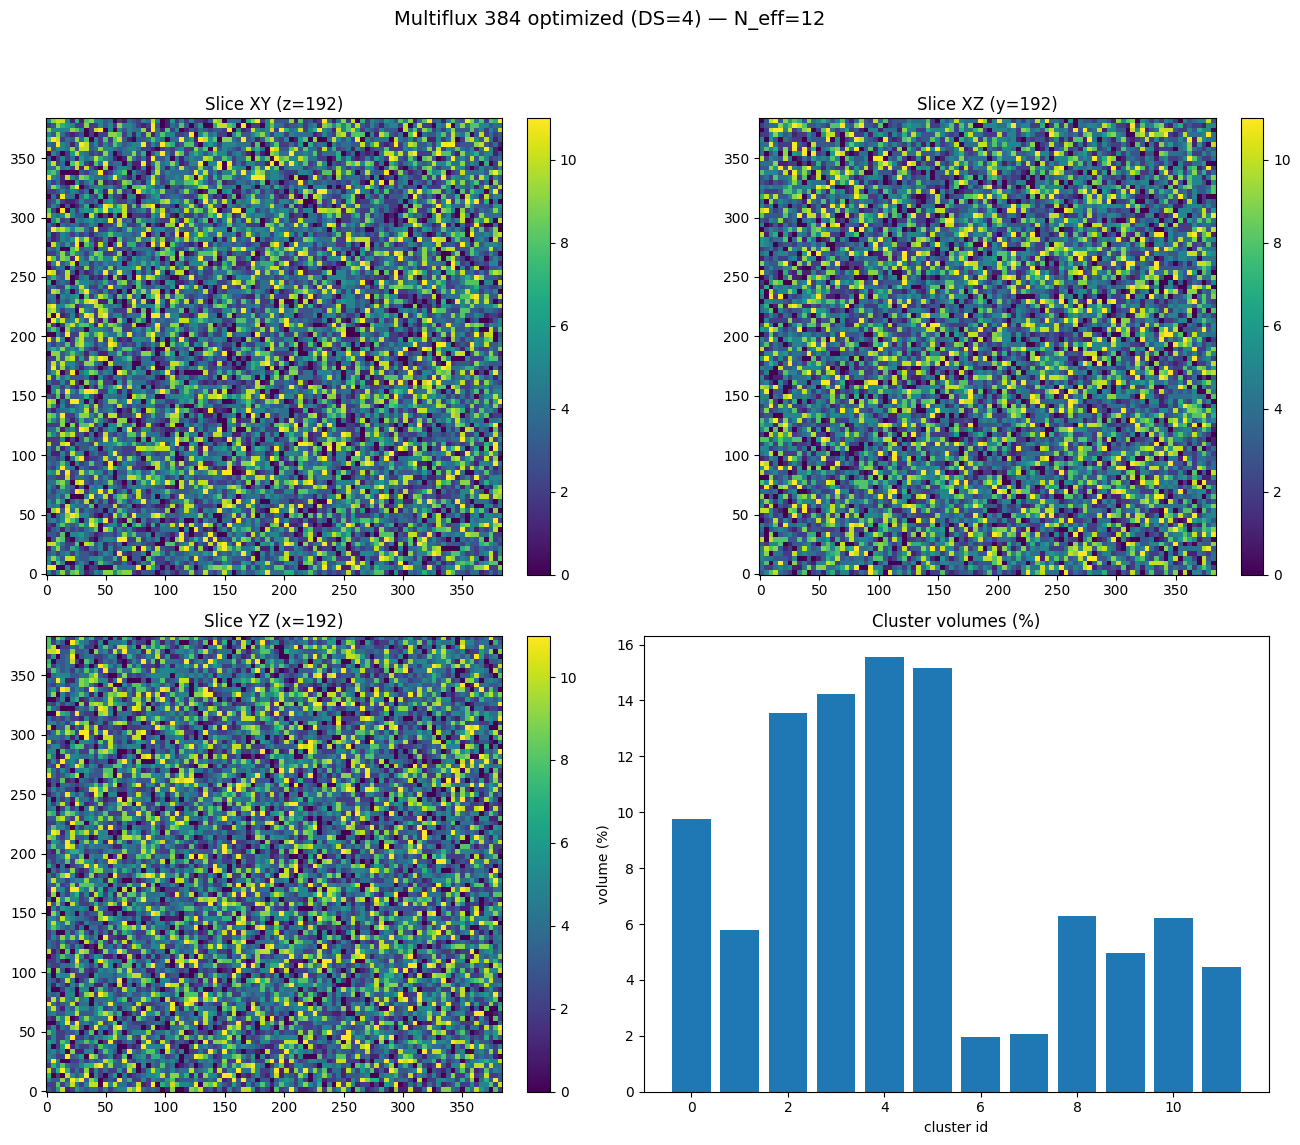

[19:42:48] Saved figure to output_multiflux_optimized/multiflux_slices_and_hist_384_optimized.png
[19:42:48] Optimized run complete. Outputs in folder: output_multiflux_optimized

SUMMARY:
Grid: 384^3 (DS=4)
Mean KE: 2.413437e-04
N_eff (cutoff 0.5%): 12
Top 5 cluster volumes (%) : 15.54, 15.15, 14.23, 13.56, 9.75
Output folder: output_multiflux_optimized


In [1]:
# Multiflux optimized (Option A) — low-memory, high-resolution HIT generator + multiflux decomposition
# License: Creative Commons Attribution-NonCommercial-ShareAlike 4.0 (CC BY-NC-SA 4.0)
# Author: Generated for MeshWave / Multiflux Lab
# Requirements: numpy, scipy, scikit-learn, matplotlib, psutil
#
# USAGE / SAFETY
# - Default N = 384 (good balance for 16GB machines); try N=256 first to validate.
# - DS controls downsampling for invariants (DS=4 => invariants on (N/4)^3 grid).
# - Script estimates memory needs and aborts if available RAM seems insufficient.
# - If you have > 32GB RAM or GPU, consider GPU notebook instead.
#
# Copy entire block into a single Jupyter cell or run as python script.

import os, time, gc, sys
import numpy as np
from scipy.fft import rfftn, irfftn, fftfreq, rfftfreq
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import psutil

# -------------------------
# PARAMETERS (edit if needed)
# -------------------------
N = 384                 # grid size (try 256 first; 384 is aggressive but often workable on 16GB)
L = 2.0 * np.pi
SEED = 42
K_CLUSTERS = 12
DS = 4                  # downsample factor for invariant grid (N//DS points per dim)
OUTDIR = "output_multiflux_optimized"
SAVE_PLOTS = True
VERBOSE = True
DTYPE = np.float32      # use float32 for physical arrays
COMPLEX_DTYPE = np.complex64  # spectral arrays
MIN_AVAILABLE_GB = 6.0  # abort if available memory below this (safety)

os.makedirs(OUTDIR, exist_ok=True)
np.random.seed(SEED)

def log(msg):
    if VERBOSE:
        print(f"[{time.strftime('%H:%M:%S')}] {msg}")

# -------------------------
# Quick memory check
# -------------------------
mem = psutil.virtual_memory()
avail_gb = mem.available / 1e9
log(f"System memory available: {avail_gb:.2f} GB")

# Rough estimation of spectral array memory: for rfftn shape (N,N,N//2+1)
nr = N//2 + 1
complex_elements = N * N * nr
bytes_per_complex = np.dtype(COMPLEX_DTYPE).itemsize
est_spectral_bytes = complex_elements * bytes_per_complex * 3  # u_hat, v_hat, w_hat
est_physical_bytes = N**3 * np.dtype(DTYPE).itemsize * 3      # u,v,w full-res
est_extra = 1.5 * 1024**3  # safety extra ~1.5GB for temporaries/overhead

est_total_gb = (est_spectral_bytes + est_physical_bytes + est_extra) / 1e9
log(f"Estimated peak memory use ~ {est_total_gb:.2f} GB (rough)")

if avail_gb < MIN_AVAILABLE_GB:
    log("WARNING: Available memory is low. Consider freeing RAM or reducing N/DS.")
if avail_gb < est_total_gb + 1.0:
    log("ERROR: Not enough available memory estimated for this run. Abort to avoid OOM.")
    raise SystemExit("Insufficient memory: reduce N or increase DS, or free RAM and retry.")

# -------------------------
# 1) Build k-grid for rfftn shape
# -------------------------
log("Building k-grid for rfftn domain (sliced in z)")
kx = 2*np.pi * fftfreq(N, d=L/N).astype(DTYPE)      # shape (N,)
ky = 2*np.pi * fftfreq(N, d=L/N).astype(DTYPE)      # shape (N,)
kz = 2*np.pi * rfftfreq(N, d=L/N).astype(DTYPE)     # shape (nr,)
KX = np.reshape(kx, (N,1,1)) * np.ones((1,N,nr), dtype=DTYPE)
KY = np.reshape(ky, (1,N,1)) * np.ones((N,1,nr), dtype=DTYPE)
KZ = np.reshape(kz, (1,1,nr)) * np.ones((N,N,1), dtype=DTYPE)
K2 = KX**2 + KY**2 + KZ**2
K = np.sqrt(K2)
mask = K2 > 0.0

# Free k arrays partially if needed later? Keep for gradient computation in spectral domain.

# -------------------------
# 2) Generate spectral random fields (rfftn) sequentially to limit peak memory
# -------------------------
log("Generating random fields and creating spectral representations (rfftn)...")
t0 = time.time()

# helper: create real random field, compute rfftn -> returns complex64 array
def rand_field_rfft():
    # create in float32 to save memory
    f = np.random.standard_normal((N,N,N)).astype(DTYPE)
    fh = rfftn(f)                   # returns complex128 by default; cast to complex64 to save mem
    fh = fh.astype(COMPLEX_DTYPE, copy=False)
    del f
    gc.collect()
    return fh

u_hat = rand_field_rfft()
v_hat = rand_field_rfft()
w_hat = rand_field_rfft()

# spectral shaping for approximate Kolmogorov -5/3: multiply amplitude by K^{-5/6}
log("Applying spectral amplitude scaling (approx k^-5/3)")
# avoid dividing by zero, mask applied
scale = np.where(mask, (K.astype(np.float32) ** (-5.0/6.0)).astype(COMPLEX_DTYPE), 0.0+0.0j)
u_hat *= scale; v_hat *= scale; w_hat *= scale
del scale
gc.collect()

# -------------------------
# 3) Solenoidal projection in spectral domain (rfftn domain)
# -------------------------
log("Applying solenoidal projection in spectral domain")
# compute k_dot = kx * u_hat + ky * v_hat + kz * w_hat
k_dot = (KX.astype(COMPLEX_DTYPE) * u_hat) + (KY.astype(COMPLEX_DTYPE) * v_hat) + (KZ.astype(COMPLEX_DTYPE) * w_hat)
# subtract projection: u_hat -= kx * (k_dot / K2)
invK2 = np.where(K2>0, 1.0 / K2, 0.0).astype(DTYPE)
invK2c = invK2.astype(COMPLEX_DTYPE)
u_hat = u_hat - (KX.astype(COMPLEX_DTYPE) * (k_dot * invK2c))
v_hat = v_hat - (KY.astype(COMPLEX_DTYPE) * (k_dot * invK2c))
w_hat = w_hat - (KZ.astype(COMPLEX_DTYPE) * (k_dot * invK2c))
del k_dot, invK2, invK2c
gc.collect()

# -------------------------
# 4) Inverse spectral -> physical (irfftn) to obtain velocity fields (float32)
# -------------------------
log("Inverse transform to physical space (irfftn) — storing as float32")
u = irfftn(u_hat).astype(DTYPE, copy=False)
v = irfftn(v_hat).astype(DTYPE, copy=False)
w = irfftn(w_hat).astype(DTYPE, copy=False)

# free spectral arrays as soon as velocities exist
del u_hat, v_hat, w_hat
gc.collect()

t1 = time.time()
log(f"Velocity fields generated in {t1-t0:.1f}s. Mean KE computing...")

KE_mean = 0.5 * np.mean(u*u + v*v + w*w, dtype=np.float64)  # compute in double for scalar accuracy
log(f"Mean kinetic energy density (scalar): {KE_mean:.6e}")

# optionally save raw velocity compressed (comment if you want minimal IO)
np.savez_compressed(os.path.join(OUTDIR, "velocity_{}_float32.npz".format(N)), u=u, v=v, w=w)
log("Saved velocity NPZ (compressed)")

# -------------------------
# 5) Compute gradients via spectral differentiation (using rfftn of each component)
#    We compute fhat again but in-place to avoid keeping two large arrays.
# -------------------------
log("Computing spectral gradients (will reuse temp spectral arrays sequentially to limit memory)")

def spectral_gradients_from_field(field):
    """Return (df/dx, df/dy, df/dz) as float32 arrays using rfftn/irfftn approach,
       performing transforms sequentially to limit memory."""
    # compute rfft of field (float32 -> complex64)
    fh = rfftn(field).astype(COMPLEX_DTYPE, copy=False)
    # multiply in spectral domain by (i*kx, i*ky, i*kz) and inverse transform
    fx = irfftn(1j * (KX.astype(COMPLEX_DTYPE) * fh)).astype(DTYPE, copy=False)
    fy = irfftn(1j * (KY.astype(COMPLEX_DTYPE) * fh)).astype(DTYPE, copy=False)
    fz = irfftn(1j * (KZ.astype(COMPLEX_DTYPE) * fh)).astype(DTYPE, copy=False)
    del fh
    gc.collect()
    return fx, fy, fz

# Compute gradients sequentially to reduce peak memory
du_dx, du_dy, du_dz = spectral_gradients_from_field(u)
dv_dx, dv_dy, dv_dz = spectral_gradients_from_field(v)
dw_dx, dw_dy, dw_dz = spectral_gradients_from_field(w)
log("Gradients computed (float32)")

# Optionally free full velocity fields if you want to reduce memory further (but keep if you plan more ops)
# del u, v, w
# gc.collect()

# -------------------------
# 6) Downsample invariants for clustering (keep DS so that (N//DS)^3 reasonably sized)
# -------------------------
log(f"Downsampling invariants with DS={DS} (feature grid = {(N//DS)}^3)")
inds = slice(0, N, DS)
u_s = u[inds, inds, inds]
v_s = v[inds, inds, inds]
w_s = w[inds, inds, inds]

du_dx_s = du_dx[inds, inds, inds]; du_dy_s = du_dy[inds, inds, inds]; du_dz_s = du_dz[inds, inds, inds]
dv_dx_s = dv_dx[inds, inds, inds]; dv_dy_s = dv_dy[inds, inds, inds]; dv_dz_s = dv_dz[inds, inds, inds]
dw_dx_s = dw_dx[inds, inds, inds]; dw_dy_s = dw_dy[inds, inds, inds]; dw_dz_s = dw_dz[inds, inds, inds]

# compute vorticity components on downsampled grid
omega_x = dw_dy_s - dv_dz_s
omega_y = du_dz_s - dw_dx_s
omega_z = dv_dx_s - du_dy_s
vort_mag = np.sqrt(omega_x**2 + omega_y**2 + omega_z**2, dtype=DTYPE)

# helicity
helicity = u_s * omega_x + v_s * omega_y + w_s * omega_z

# compute Q = 0.5 (||Omega||^2 - ||S||^2) without building full tensors if possible
# First compute relevant sums:
# trOmega2 = sum_{i,j} Omega_{ij}^2 ; trS2 similar
# Where S_ij = 0.5*(du_i/dx_j + du_j/dx_i); Omega_ij = 0.5*(du_i/dx_j - du_j/dx_i)

# compute strain-rate magnitude components efficiently
# Precompute gradient components per downsample point for readability
# S components:
S11 = 0.5 * (du_dx_s + du_dx_s)   # = du_dx_s
S22 = 0.5 * (dv_dy_s + dv_dy_s)
S33 = 0.5 * (dw_dz_s + dw_dz_s)
S12 = 0.5 * (du_dy_s + dv_dx_s)
S13 = 0.5 * (du_dz_s + dw_dx_s)
S23 = 0.5 * (dv_dz_s + dw_dy_s)

# Omega components (antisymmetric)
W12 = 0.5 * (du_dy_s - dv_dx_s)
W13 = 0.5 * (du_dz_s - dw_dx_s)
W23 = 0.5 * (dv_dz_s - dw_dy_s)

trS2 = (S11*S11 + S22*S22 + S33*S33 + 2*(S12*S12 + S13*S13 + S23*S23)).astype(DTYPE)
trOmega2 = 2*(W12*W12 + W13*W13 + W23*W23).astype(DTYPE)  # since Omega antisymmetric, diagonal zero

Q = 0.5 * (trOmega2 - trS2)

# compute lambda2: eigenvalue of M = S^2 + Omega^2 -> compute 3x3 matrix at each point (downsized)
log("Computing lambda2 on downsampled grid (this is the most expensive pointwise op)")
n_ds = u_s.shape[0]
# we'll compute eigenvalues via explicit formation of 3x3 arrays; memory is small because downsampled
M = np.empty((n_ds, n_ds, n_ds, 3, 3), dtype=DTYPE)

# fill S_ij and Omega_ij on grid
# S matrix:
M[...,0,0] = S11*S11 + W12*W12 + W13*W13  # placeholder, will instead compute S^2 + Omega^2 via multiplication
# Proper construction: compute S^2 + Omega^2 via naive multiplication small matrices per point
# Build 3x3 S and Omega per point and compute products
S_mat = np.empty((n_ds, n_ds, n_ds, 3, 3), dtype=DTYPE)
O_mat = np.empty((n_ds, n_ds, n_ds, 3, 3), dtype=DTYPE)

S_mat[...,0,0] = S11; S_mat[...,0,1] = S12; S_mat[...,0,2] = S13
S_mat[...,1,0] = S12; S_mat[...,1,1] = S22; S_mat[...,1,2] = S23
S_mat[...,2,0] = S13; S_mat[...,2,1] = S23; S_mat[...,2,2] = S33

O_mat[...,0,0] = 0.0; O_mat[...,0,1] = W12; O_mat[...,0,2] = W13
O_mat[...,1,0] = -W12; O_mat[...,1,1] = 0.0; O_mat[...,1,2] = W23
O_mat[...,2,0] = -W13; O_mat[...,2,1] = -W23; O_mat[...,2,2] = 0.0

# compute M = S^2 + Omega^2 via einsum
# M_ij = sum_k S_ik S_kj + sum_k Omega_ik Omega_kj
S2 = np.einsum('...ik,...kj->...ij', S_mat, S_mat)
O2 = np.einsum('...ik,...kj->...ij', O_mat, O_mat)
M = S2 + O2
# compute eigenvalues
eigvals = np.linalg.eigvalsh(M)   # shape (..., 3)
lambda2 = np.sort(eigvals, axis=-1)[..., -2].astype(DTYPE)
del S_mat, O_mat, S2, O2, M, eigvals
gc.collect()

# -------------------------
# 7) Build feature matrix (flatten) and standardize
# -------------------------
log("Building feature matrix and standardizing")
features = np.column_stack([
    vort_mag.ravel().astype(np.float32),
    Q.ravel().astype(np.float32),
    lambda2.ravel().astype(np.float32),
    helicity.ravel().astype(np.float32)
])
# standardize (float32)
means = features.mean(axis=0)
stds = features.std(axis=0) + 1e-12
X = (features - means) / stds
n_points = X.shape[0]
log(f"Feature matrix shape: {X.shape} (samples)")

# free large temporaries
del vort_mag, Q, lambda2, helicity, features
gc.collect()

# -------------------------
# 8) Clustering (MiniBatchKMeans)
# -------------------------
log(f"Clustering with MiniBatchKMeans (k={K_CLUSTERS})")
from sklearn.cluster import MiniBatchKMeans
mbk = MiniBatchKMeans(n_clusters=K_CLUSTERS, batch_size=16384, n_init=10, random_state=SEED)
t0 = time.time()
labels_flat = mbk.fit_predict(X)
t1 = time.time()
log(f"MiniBatchKMeans completed in {t1-t0:.1f}s")

# reshape labels to downsampled grid
n = N // DS
labels_ds = labels_flat.reshape((n,n,n))

# compute cluster volumes (fractions of downsampled grid)
counts = np.bincount(labels_flat, minlength=K_CLUSTERS)
volumes = counts / float(n_points)
N_eff = int(np.sum(counts > 0.005 * n_points))
log(f"N_eff (cutoff 0.5%): {N_eff}")

# -------------------------
# 9) Save outputs (NPZ, CSV, report)
# -------------------------
log("Saving CSV, NPZ and report")
csv_path = os.path.join(OUTDIR, f"cluster_volumes_{N}_optimized.csv")
with open(csv_path, "w") as f:
    f.write("cluster_id,count,volume_fraction\n")
    for cid, cnt, vol in zip(range(K_CLUSTERS), counts, volumes):
        f.write(f"{cid},{int(cnt)},{vol:.8f}\n")

npz_path = os.path.join(OUTDIR, f"multiflux_{N}_optimized.npz")
np.savez_compressed(npz_path,
                    meta=dict(N=N, L=float(L), seed=SEED, k_clusters=K_CLUSTERS, DS=DS),
                    counts=counts, volumes=volumes, labels_ds=labels_ds.astype(np.int16))
report_path = os.path.join(OUTDIR, "report_{}_optimized.txt".format(N))
with open(report_path, "w") as f:
    f.write("Multiflux HIT optimized run report\n")
    f.write(f"Grid: {N}^3; L={L}; seed={SEED}; k_clusters={K_CLUSTERS}\n")
    f.write(f"Mean kinetic energy density: {KE_mean:.6e}\n")
    f.write(f"N_eff (cutoff 0.50%): {N_eff}\n")
    f.write("Top 5 cluster volumes (%): " + ", ".join(f"{100*v:.2f}" for v in sorted(volumes, reverse=True)[:5]) + "\n")

log(f"Saved CSV: {csv_path}, NPZ: {npz_path}, report: {report_path}")

# -------------------------
# 10) Visualizations (minimal, last step)
# -------------------------
if SAVE_PLOTS:
    log("Generating plots (approximate upsample for display only)")
    labels_full_approx = np.repeat(np.repeat(np.repeat(labels_ds, DS, axis=0), DS, axis=1), DS, axis=2)
    labels_full_approx = labels_full_approx[:N, :N, :N]

    mid = N//2
    fig, axes = plt.subplots(2,2, figsize=(14,12))
    im0 = axes[0,0].imshow(labels_full_approx[:, :, mid], origin='lower', interpolation='nearest')
    axes[0,0].set_title(f"Slice XY (z={mid})")
    plt.colorbar(im0, ax=axes[0,0], fraction=0.046, pad=0.04)

    im1 = axes[0,1].imshow(labels_full_approx[:, mid, :].T, origin='lower', interpolation='nearest')
    axes[0,1].set_title(f"Slice XZ (y={mid})")
    plt.colorbar(im1, ax=axes[0,1], fraction=0.046, pad=0.04)

    im2 = axes[1,0].imshow(labels_full_approx[mid, :, :].T, origin='lower', interpolation='nearest')
    axes[1,0].set_title(f"Slice YZ (x={mid})")
    plt.colorbar(im2, ax=axes[1,0], fraction=0.046, pad=0.04)

    axes[1,1].bar(np.arange(K_CLUSTERS), volumes*100)
    axes[1,1].set_title("Cluster volumes (%)")
    axes[1,1].set_xlabel("cluster id")
    axes[1,1].set_ylabel("volume (%)")

    plt.suptitle(f"Multiflux {N} optimized (DS={DS}) — N_eff={N_eff}", fontsize=14)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    fig_path = os.path.join(OUTDIR, f"multiflux_slices_and_hist_{N}_optimized.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    log(f"Saved figure to {fig_path}")

log("Optimized run complete. Outputs in folder: " + OUTDIR)
print("\nSUMMARY:")
print(f"Grid: {N}^3 (DS={DS})")
print(f"Mean KE: {KE_mean:.6e}")
print(f"N_eff (cutoff 0.5%): {N_eff}")
print("Top 5 cluster volumes (%) :", ", ".join(f"{100*v:.2f}" for v in sorted(volumes, reverse=True)[:5]))
print("Output folder:", OUTDIR)
